In [1]:
import os, random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import layers, callbacks, regularizers

In [2]:
def set_all_seeds(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_all_seeds(42)

In [3]:
# Load data
df = pd.read_csv('ML-CUP25-TR.csv', comment='#', header=None)
X = df.iloc[:, 1:13].values
y = df.iloc[:, 13:].values

In [4]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [5]:
# Define Mean Euclidean Error (MEE)
def mee_metric(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

mee_scorer = make_scorer(mee_metric, greater_is_better=False) 

In [6]:
@tf.function(reduce_retracing=True)
def mee_tf(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.linalg.norm(y_true - y_pred, axis=-1))

In [7]:
# 4) Model builder (SciKeras-friendly signature)

def build_model(meta, hidden_layer_sizes=(64, 64), activation="relu", l2_rate=0.01, learning_rate=0.01):
    n_features_in_ = meta["n_features_in_"]
    n_outputs_ = meta["n_outputs_"]
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_features_in_,)))

    reg = regularizers.l2(l2_rate) if (l2_rate and l2_rate > 0) else None
    for units in hidden_layer_sizes:
        model.add(layers.Dense(units, activation=activation, kernel_regularizer=reg))

    model.add(layers.Dense(n_outputs_, activation="linear"))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss="mse", metrics=[mee_tf])
    return model

In [ ]:
reg_grid = KerasRegressor(
    model=build_model,
    epochs=500,        
    verbose=0,
    random_state=42,
)

pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("pca", PCA(n_components=4)),
    ("model", reg_grid)
])

param_grid = {
    "model__model__hidden_layer_sizes": [(32,),(64, 32), (64, 64), (128, 64), ],
    "model__model__activation": ["relu", "tanh"],
    "model__model__l2_rate": [ 0.01, 0.1],
    "model__model__learning_rate": [0.01, 0.1],
    "model__batch_size": [32, 64],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv,
    refit=True,
    n_jobs=1,   
    verbose=0,
)

gs.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=4)),
                                       ('model',
                                        KerasRegressor(epochs=500, model=<function build_model at 0x000001A545D7E830>, random_state=42, verbose=0))]),
             n_jobs=1,
             param_grid={'model__batch_size': [32, 64],
                         'model__model__activation': ['relu', 'tanh'],
                         'model__model__hidden_layer_sizes': [(64, 64),
                                                              (128, 64)],
                         'model__model__l2_rate': [0.01, 0.1],
                         'model__model__learning_rate': [0.01, 0.1]},
             scoring=make_scorer(mee_metric, greater_is_better=False, response_method='predict'))

In [9]:

print("-" * 30)
print(f"Best CV MEE: {-gs.best_score_:.4f}")
print(f"Best Params: {gs.best_params_}")

# Train MEE
y_train_pred = gs.predict(X_train)
print(f"FINAL TRAIN MEE: {mee_metric(y_train, y_train_pred):.4f}")
y_pred = gs.predict(X_test)
print(f"FINAL TEST MEE: {mee_metric(y_test, y_pred):.4f}")

------------------------------
Best CV MEE: 17.4805
Best Params: {'model__batch_size': 32, 'model__model__activation': 'tanh', 'model__model__hidden_layer_sizes': (64, 64), 'model__model__l2_rate': 0.1, 'model__model__learning_rate': 0.01}
FINAL TRAIN MEE: 12.9825
FINAL TEST MEE: 17.2650


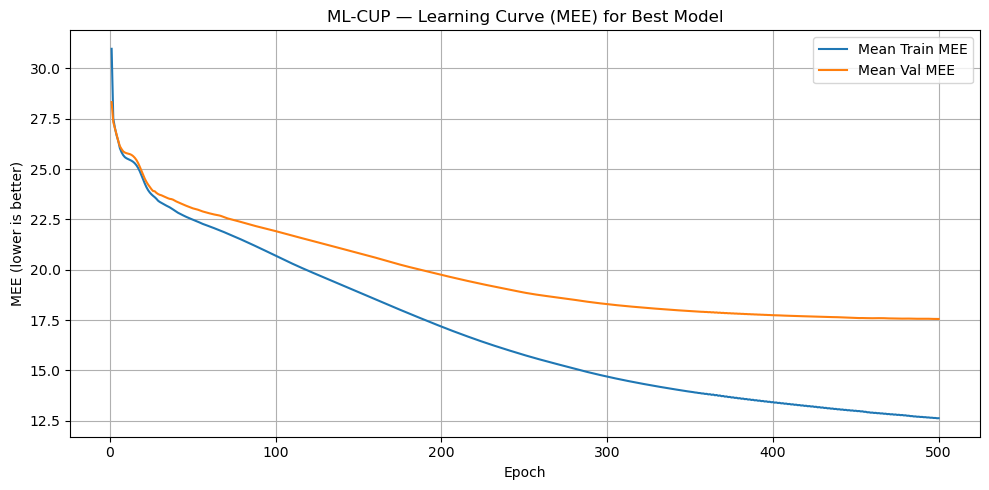

In [10]:
import matplotlib.pyplot as plt
# 5) Learning curve (MEE vs epoch) for best params

# ----------------------------
best_params = gs.best_params_

# Build a pipeline configured with best params
best_pipe = gs.best_estimator_

max_epochs = best_pipe.named_steps["model"].epochs
best_batch_size = best_pipe.named_steps["model"].batch_size


mee_train_mat, mee_val_mat = [], []

def pad(arr, L):
    arr = np.asarray(arr, dtype=float)
    return arr[:L] if len(arr) >= L else np.concatenate([arr, np.full(L - len(arr), np.nan)])

for fold, (tr_idx, va_idx) in enumerate(cv.split(X_train, y_train), start=1):
    set_all_seeds(42 + fold)
    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_va, y_va = X_train[va_idx], y_train[va_idx]

 
    X_tr_proc = best_pipe.named_steps["scaler"].fit_transform(X_tr)
    X_tr_proc = best_pipe.named_steps["pca"].fit_transform(X_tr_proc)

    X_va_proc = best_pipe.named_steps["pca"].transform(
        best_pipe.named_steps["scaler"].transform(X_va)
    )

 
    model_step = best_pipe.named_steps["model"]
    model_kwargs = model_step.get_params()


    build_kwargs = {}
    for k, v in model_kwargs.items():
        if k.startswith("model__"):
            build_kwargs[k.replace("model__", "")] = v

    meta = {"n_features_in_": X_tr_proc.shape[1], "n_outputs_": y_tr.shape[1]}
    model = build_model(meta=meta, **build_kwargs)

    hist = model.fit(
        X_tr_proc, y_tr,
        validation_data=(X_va_proc, y_va),
        epochs=max_epochs,
        batch_size=best_batch_size,
        verbose=0,
        shuffle=True
    ).history

    
    mee_train = hist.get("mee_tf", None)
    mee_val = hist.get("val_mee_tf", None)
    if mee_train is None or mee_val is None:
        raise RuntimeError(
            f"Couldn't find mee history keys. Available keys: {list(hist.keys())}"
        )

    mee_train_mat.append(pad(mee_train, max_epochs))
    mee_val_mat.append(pad(mee_val, max_epochs))

mee_train_mean = np.nanmean(np.vstack(mee_train_mat), axis=0)
mee_val_mean   = np.nanmean(np.vstack(mee_val_mat), axis=0)

mee_train_std = np.nanstd(np.vstack(mee_train_mat), axis=0)
mee_val_std   = np.nanstd(np.vstack(mee_val_mat), axis=0)

valid_epochs = np.where(~np.isnan(mee_val_mean))[0]
last_epoch = int(valid_epochs[-1]) + 1 if len(valid_epochs) else max_epochs
epochs = np.arange(1, last_epoch + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, mee_train_mean[:last_epoch], label="Mean Train MEE")
plt.plot(epochs, mee_val_mean[:last_epoch], label="Mean Val MEE")
plt.title("ML-CUP — Learning Curve (MEE) for Best Model")
plt.xlabel("Epoch")
plt.ylabel("MEE (lower is better)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()